# Исследовательский анализ данных, создание признаков

In [1]:
# В проекте будем решать задачу регрессии. Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc

# Константы
RANDOM_STATE = 5
DATA_PATH = '../data'
MODEL_PATH_1 = '../models/'

## Описание данных

В таблице с данными содержится информация:
- `url_car`	- Ссылка на объявление,
- `car_make` - Марка автомобиля,
- `car_model`	- Модель автомобиля,
- `car_gen`	- Поколение,
- `car_type` - 	Кузов,
- `car_compl` - Комплектация,
- `ann_date`	- Дата объявления,
- `ann_id`	- Уникальный номер объявления,
- `car_price`	- Цена автомобиля,
- `ann_city`	- Город,
- `link_cpl`	- Ссылка на комплектацию,
- `avail`	- Наличие,
- `year`	- Год выпуска автомобиля,
- `mileage` - Пробег автомобиля,
- `color`	- Цвет автомобиля,
- `eng_size`	- Объем двигателя (л),
- `eng_power`	- Мощность двигателя (л.с.),
- `eng_power_kw`	- Мощность электроавтомобиля (кВт),
- `eng_type`	- Тип двигателя,
- `pow_resrv`	- Запас хода (км),
- `options`	- Опции,
- `transmission`	- Трансмиссия,
- `drive`	- Привод,
- `st_wheel`	- Расположение руля,
- `condition`	- Состояние,
- `count_owner`	- Число владельцев,
- `original_pts`	- Оригинал ПТС,
- `customs`	- Растоможен.

## Вспомогательные функции

In [2]:
# Определим функцию, которая строит диаграмму размаха и гистограмму распределения
# значений определённого признака. Набор значений передаётся в качестве параметра
def show_feature_distribution(col: pd.Series) -> None:
    '''Принимает столбец со значениями, строит диаграмму размаха
    и гистограмму распределения значений'''
    fig, ax = plt.subplots(ncols=1, nrows=2,
                           figsize=(16, 6),
                           sharex=True,
                           gridspec_kw={'height_ratios': (.2, .8)})
    fig.suptitle(f'Диаграмма размаха и гистограмма распределения значений {col.name}', fontsize=14)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].tick_params(axis='y', left=False, labelleft=False)
    ax[1].grid(color='gray', linewidth = 0.5, linestyle = '--')

    if type(col[0]) != pd._libs.tslibs.timestamps.Timestamp:
        # Определим шаг шкалы для оси x
        x_step = (col.max() - col.min()) / 20
        for step in [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2,
                     0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000,
                     2000, 5000, 1e4, 2e4, 5e4, 1e5]:
            if x_step / step < 1.5:
                x_step = step
                break
        x_min = x_step * int(col.min() / x_step)
        x_max = x_step * (1 + int(col.max() / x_step))
        ax[1].set_xticks(np.arange(x_min, x_max, x_step))
        ax[0].boxplot(col, vert=False, showmeans=True)
        ax[1].hist(col, bins=np.arange(x_min, x_max, x_step / 2))
    else:
        ax[0].spines['bottom'].set_visible(False)
        ax[1].hist(col)
    ax[1].set_xlabel(f'{col.name}')
    ax[1].set_ylabel('Количество объектов')
    plt.show()

In [3]:
# Определим функцию, которая принимает на вход датасет, названия столбцов,
# название графика и осей и рисует scatter plot.
def scatter_x_y(dataset: pd.DataFrame,
                            x: str,
                            y: str,
                            title: str,
                            x_axis_name: str,
                            y_axis_name: str) -> None:
    '''Принимает на вход датасет, названия двух столбцов (x, y),
       название графика (title) и осей (x_axis_name, y_axis_name)
       и рисует scatter plot'''
    df = dataset[[x, y]].copy()
    fig = plt.figure(figsize=(11, 5))
    plt.title(title)
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)

    # Определим шаг шкалы для оси x
    if df[x].nunique() > 20:
        x_step = (df[x].max() - df[x].min()) / 20
        for step in [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2,
                      0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000,
                      2000, 5000, 1e4, 2e4, 5e4, 1e5]:
            if x_step / step < 1.5:
                x_step = step
                break
        x_min = x_step * int(df[x].min() / x_step)
        x_max = x_step * (1 + int(df[x].max() / x_step))
        plt.xticks(np.arange(x_min, x_max, x_step), rotation=90)

    # Определим шаг шкалы для оси y
    if df[y].nunique() > 20:
        y_step = (df[y].max() - df[y].min()) / 20
        for step in [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2,
                      0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000,
                      2000, 5000, 1e4, 2e4, 5e4, 1e5]:
            if y_step / step < 1.5:
                y_step = step
                break
        y_min = y_step * int(df[y].min() / y_step)
        y_max = y_step * (1 + int(df[y].max() / y_step))
        plt.yticks(np.arange(y_min, y_max, y_step))

    # Нарисуем линии сетки
    plt.grid(color='gray', linewidth = 0.5, linestyle = '--')

    # Построим график
    plt.scatter(df[x], df[y])
    plt.show()

## Загрузка данных

In [4]:
# Загрузим данные
df = pd.read_csv(os.path.join(DATA_PATH, 'data_dmitrii.csv'))

In [5]:
# Рассмотрим первые строки
df.head()

,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,...,eng_type,pow_resrv,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs
0,https://auto.ru/cars/used/sale/vaz/2105/112446...,Lada (ÂÀÇ),2105,1979-2011,Ñåäàí,1.6 MT (74 ë.ñ.),2024-08-07,1124465196,120000,Ìîñêâà,...,Áåíçèí,NaN,Ñòàíäàðò,ìåõàíè÷åñêàÿ,çàäíèé,Ëåâûé,Íå òðåáóåò ðåìîíòà,2 âëàäåëüöà,Îðèãèíàë,Ðàñòàìîæåí
1,https://auto.ru/cars/used/sale/vaz/2101/112400...,Lada (ÂÀÇ),2101,1970-1988,Ñåäàí,1.2 MT (59 ë.ñ.),2024-07-02,1124009245,45000,Áëàãîäàðíûé,...,"Áåíçèí, ãàçîáàëëîííîå îáîðóäîâàíèå",NaN,2 îïöèè,ìåõàíè÷åñêàÿ,çàäíèé,Ëåâûé,Íå òðåáóåò ðåìîíòà,3 èëè áîëåå,Äóáëèêàò,Ðàñòàìîæåí
2,https://auto.ru/cars/used/sale/vaz/2105/112563...,Lada (ÂÀÇ),2105,1979-2011,Ñåäàí,1.5 MT (71 ë.ñ.),2024-10-25,1125634799,110000,Íîâîñèáèðñê,...,Áåíçèí,NaN,1 îïöèÿ,ìåõàíè÷åñêàÿ,çàäíèé,Ëåâûé,Íå òðåáóåò ðåìîíòà,2 âëàäåëüöà,Îðèãèíàë,Ðàñòàìîæåí
3,https://auto.ru/cars/used/sale/vaz/2105/112430...,Lada (ÂÀÇ),2105,1979-2011,Ñåäàí,1.5 MT (75 ë.ñ.),2024-07-25,1124308227,250000,Ìîñêâà,...,Áåíçèí,NaN,10 îïöèé,ìåõàíè÷åñêàÿ,çàäíèé,Ëåâûé,Íå òðåáóåò ðåìîíòà,3 èëè áîëåå,Äóáëèêàò,Ðàñòàìîæåí
4,https://auto.ru/cars/used/sale/vaz/2105/112521...,Lada (ÂÀÇ),2105,1979-2011,Ñåäàí,1.6 MT (73 ë.ñ.),2024-09-28,1125218696,170000,Ãðîçíûé,...,Áåíçèí,NaN,1 îïöèÿ,ìåõàíè÷åñêàÿ,çàäíèé,Ëåâûé,Íå òðåáóåò ðåìîíòà,2 âëàäåëüöà,Îðèãèíàë,Ðàñòàìîæåí


## Типы

In [6]:
# Изучим информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37063 entries, 0 to 37062
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url_car       37063 non-null  object 
 1   car_make      37063 non-null  object 
 2   car_model     37063 non-null  object 
 3   car_gen       37063 non-null  object 
 4   car_type      37063 non-null  object 
 5   car_compl     37063 non-null  object 
 6   ann_date      37063 non-null  object 
 7   ann_id        37063 non-null  int64  
 8   car_price     37063 non-null  int64  
 9   ann_city      37063 non-null  object 
 10  link_cpl      37063 non-null  object 
 11  avail         37063 non-null  object 
 12  year          37063 non-null  int64  
 13  mileage       37063 non-null  int64  
 14  color         37063 non-null  object 
 15  eng_size      37036 non-null  float64
 16  eng_power     37063 non-null  int64  
 17  eng_power_kw  27 non-null     float64
 18  eng_type      37063 non-nu

In [7]:
# Приведём типы в соответствие с содержимым и избавимся от нулей
df['ann_date'] = pd.to_datetime(df['ann_date'], format='%Y-%m-%d')
df['car_price'] = df['car_price'].astype('float')/1000
df['mileage'] = df['mileage'].astype('float')/1000

## Дубликаты

In [8]:
# Проверим полные дубликаты без url_car, ann_id, ann_date
df.drop(['url_car', 'ann_id', 'ann_date'], axis=1).duplicated(keep=False).sum()

np.int64(20)

In [9]:
# Посмотрим на повторяющиеся объекты
df[df.drop(['url_car', 'ann_id', 'ann_date'], axis=1).duplicated(keep=False)].sort_values(
    ['car_make', 'car_model', 'car_gen', 'car_type', 'car_price'])

,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,...,eng_type,pow_resrv,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs
17831,https://auto.ru/cars/used/sale/chevrolet/lanos...,Chevrolet,Lanos,I,Ñåäàí,1.5 MT (86 ë.ñ.),2024-10-28,1125667084,205.0,Äóáîâêà,...,Áåíçèí,NaN,1 îïöèÿ,ìåõàíè÷åñêàÿ,ïåðåäíèé,Ëåâûé,Íå òðåáóåò ðåìîíòà,1 âëàäåëåö,Äóáëèêàò,Ðàñòàìîæåí
17832,https://auto.ru/cars/used/sale/chevrolet/lanos...,Chevrolet,Lanos,I,Ñåäàí,1.5 MT (86 ë.ñ.),2024-10-28,1125667083,205.0,Äóáîâêà,...,Áåíçèí,NaN,1 îïöèÿ,ìåõàíè÷åñêàÿ,ïåðåäíèé,Ëåâûé,Íå òðåáóåò ðåìîíòà,1 âëàäåëåö,Äóáëèêàò,Ðàñòàìîæåí
24296,https://auto.ru/cars/used/sale/chevrolet/monza...,Chevrolet,Monza,II Ðåñòàéëèíã,Ñåäàí,1.5 AMT (113 ë.ñ.),2024-10-14,1124902248,1970.0,Êðàñíîäàð,...,Áåíçèí,NaN,Enjoy Edition,ðîáîòèçèðîâàííàÿ,ïåðåäíèé,Ëåâûé,Íå òðåáóåò ðåìîíòà,1 âëàäåëåö,Îðèãèíàë,Ðàñòàìîæåí
25414,https://auto.ru/cars/used/sale/chevrolet/monza...,Chevrolet,Monza,II Ðåñòàéëèíã,Ñåäàí,1.5 AMT (113 ë.ñ.),2024-10-10,1124902250,1970.0,Êðàñíîäàð,...,Áåíçèí,NaN,Enjoy Edition,ðîáîòèçèðîâàííàÿ,ïåðåäíèé,Ëåâûé,Íå òðåáóåò ðåìîíòà,1 âëàäåëåö,Îðèãèíàë,Ðàñòàìîæåí
17278,https://auto.ru/cars/used/sale/chevrolet/niva/...,Chevrolet,Niva,I,Âíåäîðîæíèê 5 äâ.,1.7 MT (80 ë.ñ.) 4WD,2024-08-13,1124548113,550.0,Ñòàðîäåðåâÿíêîâñêàÿ,...,Áåíçèí,NaN,1 îïöèÿ,ìåõàíè÷åñêàÿ,ïîëíûé,Ëåâûé,Íå òðåáóåò ðåìîíòà,3 èëè áîëåå,Äóáëèêàò,Ðàñòàìîæåí
17584,https://auto.ru/cars/used/sale/chevrolet/niva/...,Chevrolet,Niva,I,Âíåäîðîæíèê 5 äâ.,1.7 MT (80 ë.ñ.) 4WD,2024-08-19,1124622207,550.0,Ñòàðîäåðåâÿíêîâñêàÿ,...,Áåíçèí,NaN,1 îïöèÿ,ìåõàíè÷åñêàÿ,ïîëíûé,Ëåâûé,Íå òðåáóåò ðåìîíòà,3 èëè áîëåå,Äóáëèêàò,Ðàñòàìîæåí
2353,https://auto.ru/cars/used/sale/vaz/2109/112509...,Lada (ÂÀÇ),2109,1987-2006,Õýò÷áåê 5 äâ.,1.5 MT (68 ë.ñ.),2024-09-19,1125090143,75.0,Áîëüøîé Èñòîê,...,Áåíçèí,NaN,1 îïöèÿ,ìåõàíè÷åñêàÿ,ïåðåäíèé,Ëåâûé,Íå òðåáóåò ðåìîíòà,3 èëè áîëåå,Îðèãèíàë,Ðàñòàìîæåí
2528,https://auto.ru/cars/used/sale/vaz/2109/112510...,Lada (ÂÀÇ),2109,1987-2006,Õýò÷áåê 5 äâ.,1.5 MT (68 ë.ñ.),2024-09-20,1125102643,75.0,Áîëüøîé Èñòîê,...,Áåíçèí,NaN,1 îïöèÿ,ìåõàíè÷åñêàÿ,ïåðåäíèé,Ëåâûé,Íå òðåáóåò ðåìîíòà,3 èëè áîëåå,Îðèãèíàë,Ðàñòàìîæåí
2087,https://auto.ru/cars/used/sale/vaz/2109/112511...,Lada (ÂÀÇ),2109,1987-2006,Õýò÷áåê 5 äâ.,21093i 1.5 MT (78 ë.ñ.),2024-09-21,1125113218,290.0,Ìàõà÷êàëà,...,Áåíçèí,NaN,1 îïöèÿ,ìåõàíè÷åñêàÿ,ïåðåäíèé,Ëåâûé,Íå òðåáóåò ðåìîíòà,3 èëè áîëåå,Îðèãèíàë,Ðàñòàìîæåí
3290,https://auto.ru/cars/used/sale/vaz/2109/112513...,Lada (ÂÀÇ),2109,1987-2006,Õýò÷áåê 5 äâ.,21093i 1.5 MT (78 ë.ñ.),2024-09-23,1125139249,290.0,Ìàõà÷êàëà,...,Áåíçèí,NaN,1 îïöèÿ,ìåõàíè÷åñêàÿ,ïåðåäíèé,Ëåâûé,Íå òðåáóåò ðåìîíòà,3 èëè áîëåå,Îðèãèíàë,Ðàñòàìîæåí


Видим, что имеются дубликаты. Объявления об одном и том же автомобиле подано дважды. Избавимся от дублей.

In [10]:
df = df[~df.drop(['url_car', 'ann_id', 'ann_date'], axis=1).duplicated(keep='first')]

In [11]:
# Проверим полные дубликаты без url_car, ann_id, ann_date
df.drop(['url_car', 'ann_id', 'ann_date'], axis=1).duplicated(keep=False).sum()

np.int64(0)

## Пропуски

Раздел в стадии разработки. После получения всех данных будет проработан

## Исследование признаков

### Цена автомобиля (price) Целевой признак.

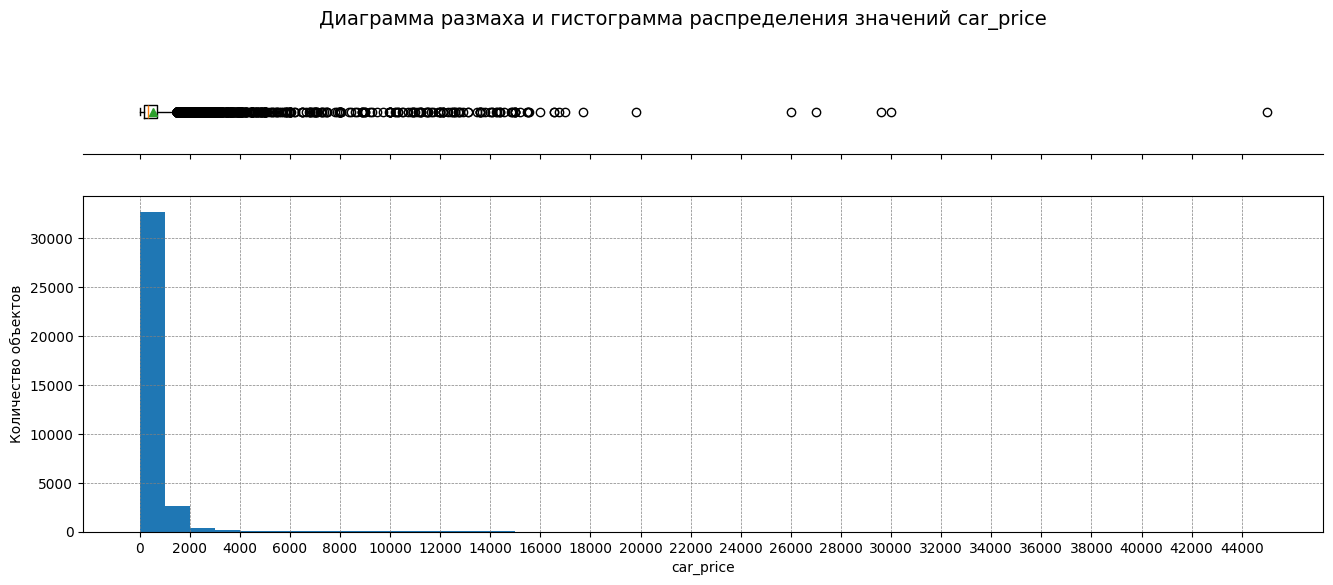

In [24]:
show_feature_distribution(df['car_price'])

Видим, что практически все автомобили в выборке имеют цену ниже 4 млн руб, при этом имеются выбросы до ~44 млн руб.

### Год выпуска автомобиля (year)

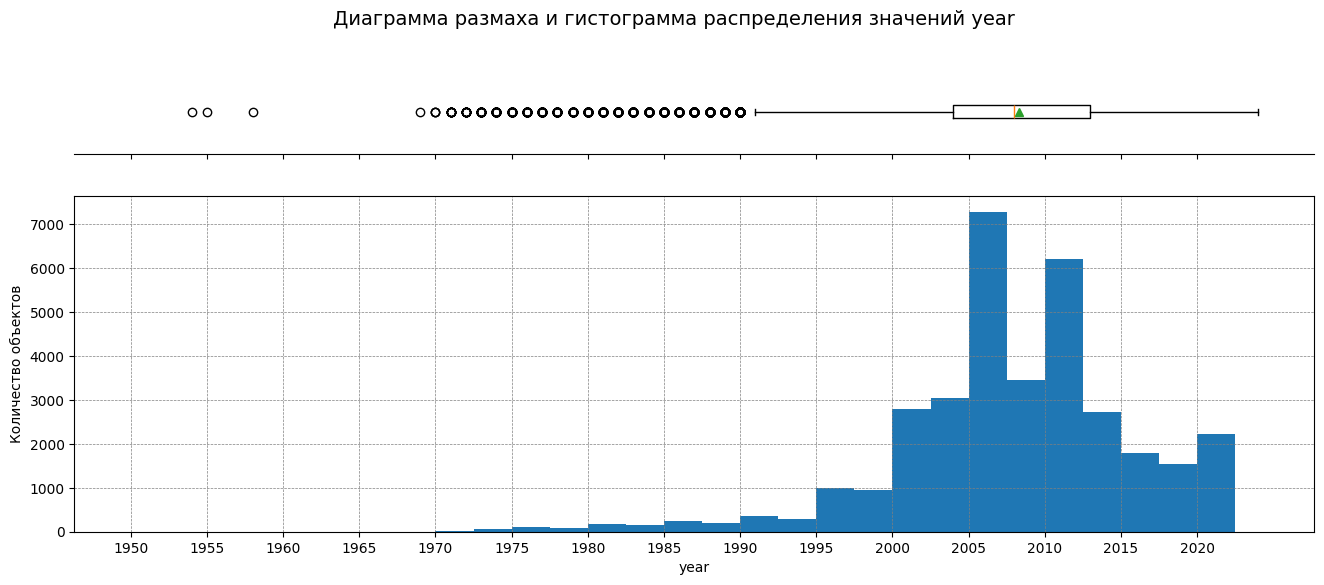

In [25]:
show_feature_distribution(df['year'])

### Мощность двигателя (л.с.)

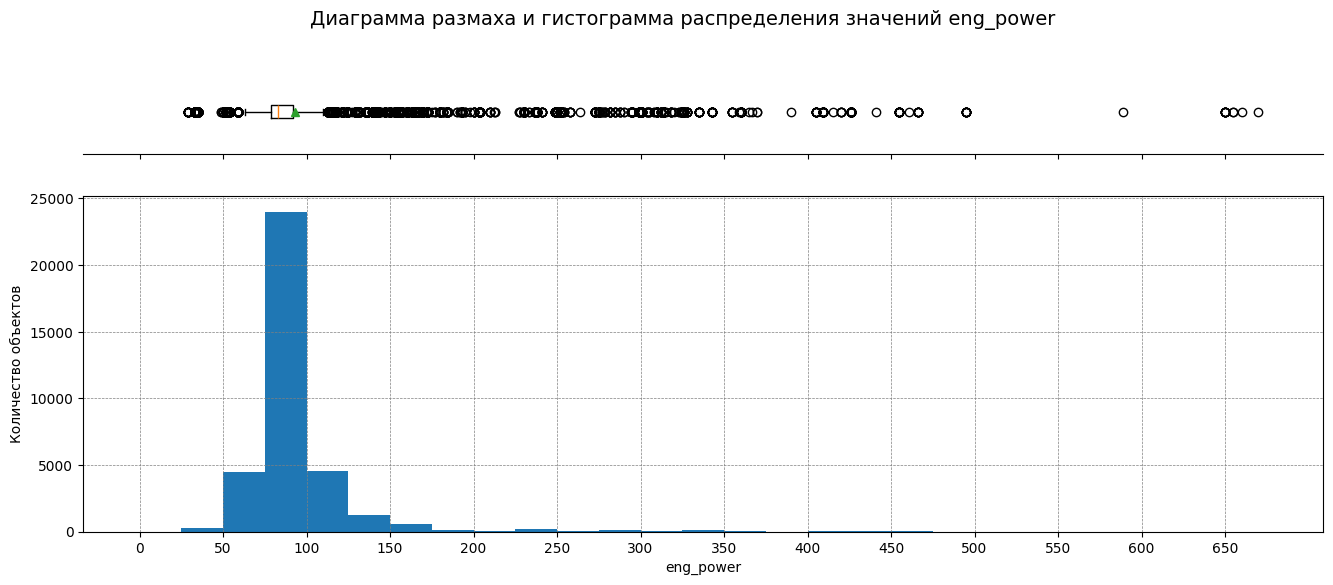

In [27]:
show_feature_distribution(df['eng_power'])

### Объём двигателя (eng_size)

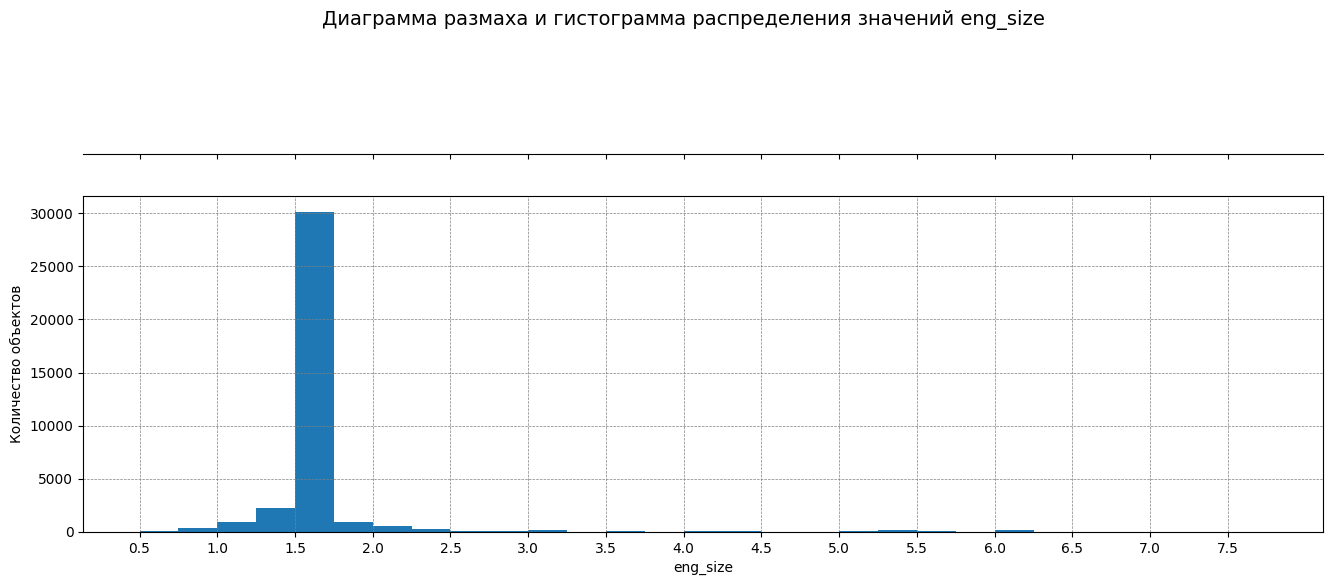

In [26]:
show_feature_distribution(df['eng_size'])